In [14]:
"""
Discriminator and Generator implementation from DCGAN paper
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 32 x 32
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
#             self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 4, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
#             self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 4, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 32 x 32
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 32, 32
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


test()

In [3]:
from sklearn.utils import shuffle
from PIL import Image
import numpy as np

RANDOM_SEED = 228


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir        # example: 'dataset/train'
        self.transform = transform    
        self.labeled_objects = []   # в формате (<путь до файла>, <номер класса>)
        for dirname, dirs, files in os.walk(self.data_dir):
            for filename in files:
                fname_without_ext, extension = os.path.splitext(filename)
                self.labeled_objects.append((join(dirname, filename),
                                             int(fname_without_ext)))   

        self.labeled_objects = shuffle(self.labeled_objects, 
                                       random_state=RANDOM_SEED)
        
    def __getitem__(self, idx):
        img_name = self.labeled_objects[idx][0]
        image = Image.open(img_name)
        label = torch.tensor([self.labeled_objects[idx][1]])
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    def __len__(self):
        return len(self.labeled_objects)

In [ ]:
# import os
# from os.path import join

# root="../../DATA/archive/"

In [ ]:
# import matplotlib.pyplot as plt

# train_dataset = MyDataset(root + 'DIV2K_train_HR', transforms)
# # val_dataset = MyDataset(root + 'DIV2K_valid_HR', transforms)

# obg_num = 11


# img, label = train_dataset[obg_num]
# img, label = val_dataset[obg_num]

In [ ]:
# # Just very simple checks
# assert isinstance(train_dataset[0], tuple)
# assert len(train_dataset[0]) == 2
# print("tests passed")

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 64
IMAGE_SIZE = 32
CHANNELS_IMG = 3
NOISE_DIM = 32

NUM_EPOCHS = 20

FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=4),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
        
    ]
)

In [ ]:
dataset = MyDataset(root + 'DIV2K_train_HR', transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs_b64/real")
writer_fake = SummaryWriter(f"logs_b64/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    # enumerate
    # batch_idx
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, NOISE_DIM, 3).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

In [12]:
import torchvision

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True)

0it [00:00, ?it/s]

100%|█████████▉| 168337408/169001437 [00:19<00:00, 11411987.72it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


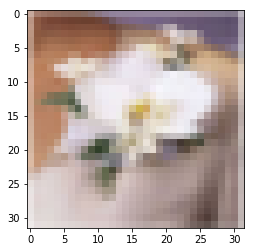

169009152it [00:30, 11411987.72it/s]                               

In [13]:
import matplotlib.pyplot as plt

plt.imshow(trainset[1000][0])